### Introduction

In this post we will cover how to convert a dataset into _.tfrecord_ file.
Binary files are sometimes easier to use, because you don't have to specify
different directories for images and groundtruth annotations. While storing your data
in binary file, you have your data in one block of memory, compared to storing
each image and annotation separately. Openning a file is a considerably
time-consuming operation especially if you use _hdd_ and not _ssd_, because it
involves moving the disk reader head and that takes quite some time. Overall,
by using binary files you make it easier to distribute and make
the data better aligned for efficient reading.

The post consists of tree parts: in the first part, we demonstrate how you can
get raw data bytes of any image using _numpy_ which is in some sense similar to what you do
when converting your dataset to binary format. Second part shows how to convert
a dataset to _tfrecord_ file without defining a computational graph and only by 
employing some built-in _tensorflow_ functions. Third part explains how to
define a model for reading your data from created binary file and batch it
in a random manner, which is necessary during training.

### Getting raw data bytes in numpy

Here we demonstrate how you can get raw data bytes of an image (any ndarray)
and how to restore the image back. We point out that during this operation
the information about the dimensions of the image is lost and we have to 
use it to recover the original image. This is one of the reasons why
we will have to store the raw image representation along with the dimensions
of the original image.

In the following examples, we convert the image into the raw representation,
restore it and make sure that we original image and restored one are the same.

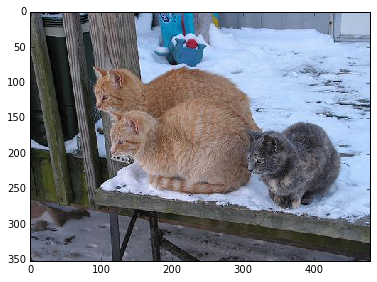

In [1]:
%matplotlib inline

import numpy as np
import skimage.io as io

cat_img = io.imread('cat.jpg')
io.imshow(cat_img)

In [2]:
# Let's convert the picture into string representation
# using the ndarray.tostring() function 
cat_string = cat_img.tostring()

# Now let's convert the string back to the image
# Important: the dtype should be specified
# otherwise the reconstruction will be errorness
# Reconstruction is 1d, so we need sizes of image
# to fully reconstruct it.
reconstructed_cat_1d = np.fromstring(cat_string, dtype=np.uint8)

# Here we reshape the 1d representation
# This is the why we need to store the sizes of image
# along with its serialized representation.
reconstructed_cat_img = reconstructed_cat_1d.reshape(cat_img.shape)

# Let's check if we got everything right and compare
# reconstructed array to the original one.
np.allclose(cat_img, reconstructed_cat_img)

True

### Creating a _.tfrecord_ file and reading it without defining a graph

Here we show how to write a small dataset (three images/annotations from _PASCAL VOC_) to
_.tfrrecord_ file and read it without defining a computational graph.

We also make sure that images that we read back from _.tfrecord_ file are equal to
the original images. Pay attention that we also write the sizes of the images along with
the image in the raw format. We showed an example on why we need to also store the size
in the previous section.

In [3]:
# Get some image/annotation pairs for example 
filename_pairs = [
('/home/dpakhom1/tf_projects/segmentation/VOCdevkit/VOCdevkit/VOC2012/JPEGImages/2007_000032.jpg',
'/home/dpakhom1/tf_projects/segmentation/VOCdevkit/VOCdevkit/VOC2012/SegmentationClass/2007_000032.png'),
('/home/dpakhom1/tf_projects/segmentation/VOCdevkit/VOCdevkit/VOC2012/JPEGImages/2007_000039.jpg',
'/home/dpakhom1/tf_projects/segmentation/VOCdevkit/VOCdevkit/VOC2012/SegmentationClass/2007_000039.png'),
('/home/dpakhom1/tf_projects/segmentation/VOCdevkit/VOCdevkit/VOC2012/JPEGImages/2007_000063.jpg',
'/home/dpakhom1/tf_projects/segmentation/VOCdevkit/VOCdevkit/VOC2012/SegmentationClass/2007_000063.png')
                 ]

In [4]:
%matplotlib inline

# Important: We are using PIL to read .png files later.
# This was done on purpose to read indexed png files
# in a special way -- only indexes and not map the indexes
# to actual rgb values. This is specific to PASCAL VOC
# dataset data. If you don't want thit type of behaviour
# consider using skimage.io.imread()
from PIL import Image
import numpy as np
import skimage.io as io
import tensorflow as tf


def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

tfrecords_filename = 'pascal_voc_segmentation.tfrecords'

writer = tf.python_io.TFRecordWriter(tfrecords_filename)

# Let's collect the real images to later on compare
# to the reconstructed ones
original_images = []

for img_path, annotation_path in filename_pairs:
    
    img = np.array(Image.open(img_path))
    annotation = np.array(Image.open(annotation_path))
    
    # The reason to store image sizes was demonstrated
    # in the previous example -- we have to know sizes
    # of images to later read raw serialized string,
    # convert to 1d array and convert to respective
    # shape that image used to have.
    height = img.shape[0]
    width = img.shape[1]
    
    # Put in the original images into array
    # Just for future check for correctness
    original_images.append((img, annotation))
    
    img_raw = img.tostring()
    annotation_raw = annotation.tostring()
    
    example = tf.train.Example(features=tf.train.Features(feature={
        'height': _int64_feature(height),
        'width': _int64_feature(width),
        'image_raw': _bytes_feature(img_raw),
        'mask_raw': _bytes_feature(annotation_raw)}))
    
    writer.write(example.SerializeToString())

writer.close()

In [5]:
reconstructed_images = []

record_iterator = tf.python_io.tf_record_iterator(path=tfrecords_filename)

for string_record in record_iterator:
    
    example = tf.train.Example()
    example.ParseFromString(string_record)
    
    height = int(example.features.feature['height']
                                 .int64_list
                                 .value[0])
    
    width = int(example.features.feature['width']
                                .int64_list
                                .value[0])
    
    img_string = (example.features.feature['image_raw']
                                  .bytes_list
                                  .value[0])
    
    annotation_string = (example.features.feature['mask_raw']
                                .bytes_list
                                .value[0])
    
    img_1d = np.fromstring(img_string, dtype=np.uint8)
    reconstructed_img = img_1d.reshape((height, width, -1))
    
    annotation_1d = np.fromstring(annotation_string, dtype=np.uint8)
    
    # Annotations don't have depth (3rd dimension)
    reconstructed_annotation = annotation_1d.reshape((height, width))
    
    reconstructed_images.append((reconstructed_img, reconstructed_annotation))
    

In [6]:
# Let's check if the reconstructed images match
# the original images

for original_pair, reconstructed_pair in zip(original_images, reconstructed_images):
    
    img_pair_to_compare, annotation_pair_to_compare = zip(original_pair,
                                                          reconstructed_pair)
    print(np.allclose(*img_pair_to_compare))
    print(np.allclose(*annotation_pair_to_compare))


True
True
True
True
True
True


### Defining the graph to read and batch images from _.tfrecords_

Here we define a graph to read and batch images from the file that we have created
previously. It is very important to randomly shuffle images during training and depending
on the application we have to use different batch size.

It is very important to point out that if we use batching -- we have to define
the sizes of images beforehand. This may sound like a limitation, but actually in the
Image Classification and Image Segmentation fields the training is performed on the images
of the same size. 

The code provided here is partially based on [this official example](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/how_tos/reading_data/fully_connected_reader.py) and code from [this stackoverflow question](http://stackoverflow.com/questions/35028173/how-to-read-images-with-different-size-in-a-tfrecord-file).
Also if you want to know how you can control the batching according to your need read [these docs](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/g3doc/api_docs/python/functions_and_classes/shard2/tf.train.shuffle_batch.md)
.

In [1]:
%matplotlib inline

import tensorflow as tf
import skimage.io as io

IMAGE_HEIGHT = 384
IMAGE_WIDTH = 384

tfrecords_filename = 'pascal_voc_segmentation.tfrecords'

def read_and_decode(filename_queue):
    
    reader = tf.TFRecordReader()

    _, serialized_example = reader.read(filename_queue)

    features = tf.parse_single_example(
      serialized_example,
      # Defaults are not specified since both keys are required.
      features={
        'height': tf.FixedLenFeature([], tf.int64),
        'width': tf.FixedLenFeature([], tf.int64),
        'image_raw': tf.FixedLenFeature([], tf.string),
        'mask_raw': tf.FixedLenFeature([], tf.string)
        })

    # Convert from a scalar string tensor (whose single string has
    # length mnist.IMAGE_PIXELS) to a uint8 tensor with shape
    # [mnist.IMAGE_PIXELS].
    image = tf.decode_raw(features['image_raw'], tf.uint8)
    annotation = tf.decode_raw(features['mask_raw'], tf.uint8)
    
    height = tf.cast(features['height'], tf.int32)
    width = tf.cast(features['width'], tf.int32)
    
    image_shape = tf.pack([height, width, 3])
    annotation_shape = tf.pack([height, width, 1])
    
    image = tf.reshape(image, image_shape)
    annotation = tf.reshape(annotation, annotation_shape)
    
    image_size_const = tf.constant((IMAGE_HEIGHT, IMAGE_WIDTH, 3), dtype=tf.int32)
    annotation_size_const = tf.constant((IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=tf.int32)
    
    # Random transformations can be put here: right before you crop images
    # to predefined size. To get more information look at the stackoverflow
    # question linked above.
    
    resized_image = tf.image.resize_image_with_crop_or_pad(image=image,
                                           target_height=IMAGE_HEIGHT,
                                           target_width=IMAGE_WIDTH)
    
    resized_annotation = tf.image.resize_image_with_crop_or_pad(image=annotation,
                                           target_height=IMAGE_HEIGHT,
                                           target_width=IMAGE_WIDTH)
    
    
    images, annotations = tf.train.shuffle_batch( [resized_image, resized_annotation],
                                                 batch_size=2,
                                                 capacity=30,
                                                 num_threads=2,
                                                 min_after_dequeue=10)
    
    return images, annotations

(384, 384, 3)
current batch


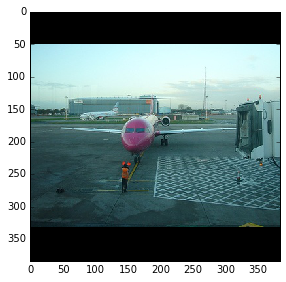

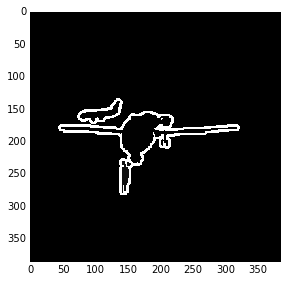

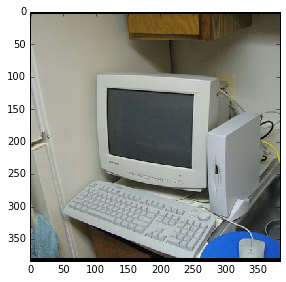

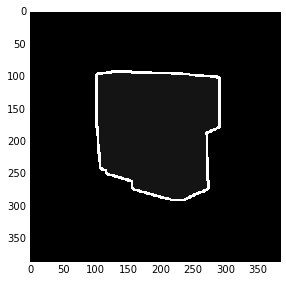

(384, 384, 3)
current batch


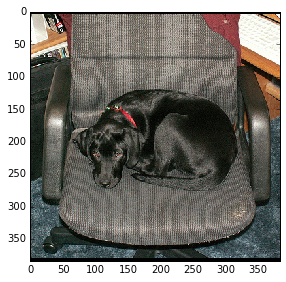

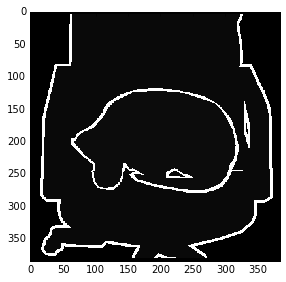

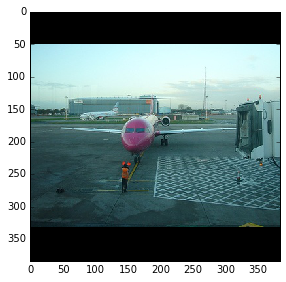

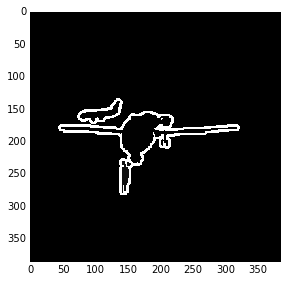

(384, 384, 3)
current batch


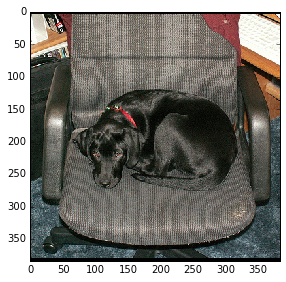

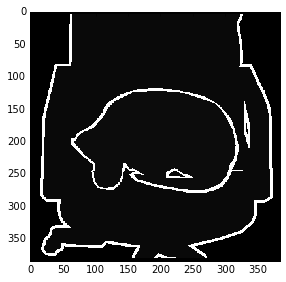

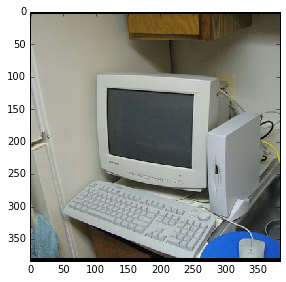

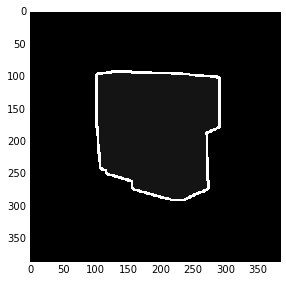

In [2]:
filename_queue = tf.train.string_input_producer(
    [tfrecords_filename], num_epochs=10)

# Even when reading in multiple threads, share the filename
# queue.
image, annotation = read_and_decode(filename_queue)

# The op for initializing the variables.
init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())

with tf.Session()  as sess:
    
    sess.run(init_op)
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    
    # Let's read off 3 batches just for example
    for i in xrange(3):
    
        img, anno = sess.run([image, annotation])
        print(img[0, :, :, :].shape)
        
        print('current batch')
        
        # We selected the batch size of two
        # So we should get two image pairs in each batch
        # Let's make sure it is random

        io.imshow(img[0, :, :, :])
        io.show()

        io.imshow(anno[0, :, :, 0])
        io.show()
        
        io.imshow(img[1, :, :, :])
        io.show()

        io.imshow(anno[1, :, :, 0])
        io.show()
        
    
    coord.request_stop()
    coord.join(threads)


### Conclusion and Discussion

In this post we covered how to convert a dataset into _.tfrecord_ format,
made sure that we have the same data and saw how to define a graph to
read and batch files from the created file.